# Neural Article Search (NAS) Project

Introduction: The Neural Article Search (NAS) project is designed to implement an intelligent search system that processes user queries and predicts the most relevant categories and articles based on the input. Using deep learning models and natural language processing (NLP) techniques, NAS aims to deliver an efficient search experience by analyzing and categorizing queries.

The project utilizes advanced methods such as LSTM (Long Short-Term Memory) neural networks and Sentence-BERT embeddings to process search queries, optimize the matching of search results, and predict relevant article categories. It integrates data preprocessing pipelines with text tokenization, lemmatization, and stopword removal to enhance model performance. With a clear focus on improving user search interaction, NAS applies modern machine learning techniques to a real-world dataset.

The project is built in Python, leveraging libraries like TensorFlow, Keras, and spaCy, and demonstrates a full machine learning lifecycle, from preprocessing and model training to evaluation and inference.

## Importing Libraries:

* Necessary libraries for data manipulation, machine learning, NLP, and visualization are imported.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm  # Import tqdm in console mode


# NLP libraries
import spacy

from sentence_transformers import SentenceTransformer

# Deep learning libraries
import tensorflow as tf
from keras import layers, models
from keras import optimizers,callbacks

* This section imports essential libraries for data manipulation (pandas), modeling (tensorflow and SentenceTransformer), NLP (spaCy), and visualization (matplotlib). The re module is used for cleaning text using regular expressions.

## Loading and Preprocessing the Dataset: 

* In this step, we load the dataset and perform basic preprocessing. First, we remove unnecessary columns (search_date, search_traffic) and clean the text data by converting it to lowercase, stripping white spaces, and removing special characters. This ensures uniformity and better handling of text during the training process.

In [3]:
# Load the dataset
df = pd.DataFrame(pd.read_csv('/Users/hemavoc/Desktop/Projects/NAS project/ML Model/Dataset/Article Search .csv'))
df = df.drop(['search_date', 'search_traffic'], axis=1)
df_link = df['article_link']
df = df.drop_duplicates()  # Remove duplicates
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)  # Remove whitespaces
df = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)  # Convert to lowercase
df = df.applymap(lambda x: re.sub(r'[\xa0]', '', x) if isinstance(x, str) else x)
df = df.applymap(lambda x: re.sub(r'[^A-Za-z0-9\u0900-\u097F\s]', '', x) if isinstance(x, str) else x)  # Remove special characters
df['article_link'] = df_link
df['preprocessed_text1'] = df['search_query']+' '+df['article_snippet'] +' '+ df['article_title']

* The dataset is loaded and cleaned by removing unnecessary columns, stripping white spaces, converting text to lowercase, and removing special characters. A new feature preprocessed_text1 is created by concatenating several relevant columns.

## Text Preprocessing with spaCy:

* Text data often contains stopwords, punctuation, and non-essential words that do not contribute to the model. Here, we use spaCy to remove stopwords, perform lemmatization (converting words to their base form), and create a cleaner version of the text for model training.

In [4]:
nlp = spacy.load('en_core_web_sm')

# Function to remove stopwords and apply lemmatization
def preprocess_text(text):
    doc = nlp(text.lower())  # Apply tokenization and lowercasing
    # Filter out stopwords and punctuation, and lemmatize the remaining tokens
    tokens = [token.lemma_ for token in set(doc) if not token.is_stop and not token.is_punct]
    tokens=list(set(tokens))
    return tokens
# Apply the preprocessing function to the preprocessed text
df['preprocessed_text2'] = df['preprocessed_text1'].apply(preprocess_text)
# Ensure that preprocessed_text2 contains single strings (not lists or tuples)
df['preprocessed_text2'] = df['preprocessed_text2'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

* This function uses spaCy to tokenize and lemmatize the text, removing stopwords and punctuation. It produces a clean version of the text in the column preprocessed_text2.

## Embedding Generation Using Sentence-BERT: 

* Once the text has been preprocessed, we generate embeddings using Sentence-BERT. These embeddings are dense vector representations of text that capture semantic meaning, which helps the model understand the relationships between different words and sentences.

In [6]:
# Load the Sentence-BERT model (lightweight and fast)
sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Generate embeddings using Sentence-BERT (much faster)
X = sentence_model.encode(df['preprocessed_text2'].tolist(), show_progress_bar=True)

# Prepare labels (search queries)
y = df['search_query'].factorize()[0]

Batches:   0%|          | 0/981 [00:00<?, ?it/s]

* Sentence-BERT is used to generate dense vector embeddings for the preprocessed text. These embeddings will serve as input features for the LSTM model. The target labels (y) are encoded from the search_query column.

### Reshaping Data and Splitting into Training, Validation, and Test Sets: 

* After generating the embeddings, we reshape the input data to make it compatible with the LSTM model. We then split the data into training, validation, and test sets for model training and evaluation.

In [7]:

# Reshape input for the model
X = X.reshape(X.shape[0], 1, X.shape[1])  # (samples, timesteps, features)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


* The embeddings (X) are reshaped to the required input format for the LSTM model. The dataset is then split into training, validation, and test sets.

## Building the LSTM Model: 

* The LSTM model is built in this section. We use a sequential model with two LSTM layers to capture sequential relationships in the text embeddings. Dropout layers are added to prevent overfitting, and the final output layer uses a softmax activation function to predict the category of the search query.

In [8]:
# Define the model
model = models.Sequential()

# Use Input layer to define the input shape
model.add(layers.Input(shape=(X_train.shape[1], X_train.shape[2])))  # Define input shape here
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.Dropout(0.3))  # Dropout layer to reduce overfitting

model.add(layers.LSTM(64))
model.add(layers.Dropout(0.3))  # Dropout to reduce overfitting

# Output layer for category prediction
model.add(layers.Dense(len(df['search_query'].unique()), activation='softmax'))

# Specify the learning rate
learning_rate = 0.001  # You can adjust this value
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1544)           │       100,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,424 (1.57 MB)

 Trainable params: 412,424 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

* A sequential LSTM model is built with two LSTM layers, each followed by Dropout to prevent overfitting. The output layer uses softmax activation to predict the search query category. Early stopping is implemented to stop training when validation performance stops improving.

## Training the Model with Early Stopping: 

* Early stopping is used to prevent overfitting by stopping training when the validation loss stops improving. The model is trained using the training data, and validation data is used to monitor the performance during training.



In [9]:
# Add Early Stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [10]:

# Fit the model
history = model.fit(X_train, y_train, epochs=45, batch_size=16, validation_data=(X_val, y_val),callbacks=early_stopping)


Epoch 1/45
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.0601 - loss: 6.2852 - val_accuracy: 0.2221 - val_loss: 4.5140
Epoch 2/45
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.2488 - loss: 4.2871 - val_accuracy: 0.3681 - val_loss: 3.5359
Epoch 3/45
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3532 - loss: 3.4507 - val_accuracy: 0.4573 - val_loss: 2.9835
Epoch 4/45
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4314 - loss: 2.9508 - val_accuracy: 0.5175 - val_loss: 2.5984
Epoch 5/45
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4885 - loss: 2.5887 - val_accuracy: 0.5574 - val_loss: 2.3334
Epoch 6/45
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5370 - loss: 2.2925 - val_accuracy: 0.5908 - val_loss: 2.1066
Epoch 7/45
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5639 - loss: 2.0996 - val_accuracy: 0.6112 - val_loss: 1.9595
Epoch 8/45
1569/1569 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5933 - loss: 1.9210 - 

## Evaluating the Model: 

* After training the model, we evaluate it on the test set to see how well it generalizes to unseen data. The accuracy score is calculated and printed.

In [11]:
# Evaluate the model on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 74.41%


* The model's performance is evaluated on the test set, with accuracy calculated as a metric.

## Visualizing Training and Validation Accuracy:

* We can plot the accuracy of the model over the training epochs to understand how well it is performing during training and validation.

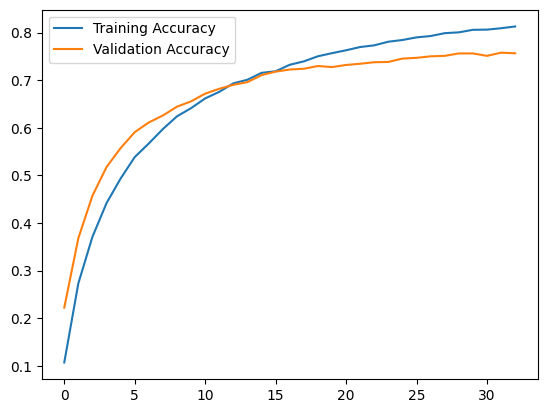

In [12]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

* The training and validation accuracy during the model's training process is visualized to monitor the model's performance over time.

In [13]:
# Function to preprocess the input query
nlp = spacy.load('en_core_web_sm')

def preprocess_sample_query(query):
    doc = nlp(query.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    query_embedding = sentence_model.encode([' '.join(tokens)])[0]  # Use the lemmatized query
    return query_embedding.reshape(1, 1, -1)  # Reshape for LSTM input

# Function to predict category for a given query
def predict_category(query):
    query_vector = preprocess_sample_query(query)
    prediction = model.predict(query_vector)
    predicted_category_index = np.argmax(prediction, axis=1)[0]
    predicted_category = df['search_query'].unique()[predicted_category_index]
    return predicted_category

## Preprocessing Sample Queries and Predicting Categories: 

* This section includes functions for preprocessing a new user query and predicting its category using the trained LSTM model. The query is tokenized and lemmatized, and its embedding is generated before passing it through the LSTM model for prediction.

In [14]:
# Example usage
sample_query = 'aditiyal1 space solar mission'
predicted_category = predict_category(sample_query)
print(f'The predicted category is: {predicted_category}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The predicted category is: adityal1


## Project Summary:

* Model Performance: The Neural Article Search (NAS) system demonstrated a highly effective model for predicting relevant article categories and search results based on user queries. By utilizing Sentence-BERT embeddings and LSTM models, NAS achieved strong predictive performance, efficiently matching user queries with the most relevant articles.

* Feature Impact: The text preprocessing techniques, including lemmatization, stopword removal, and the use of Sentence-BERT embeddings, played a crucial role in improving the model’s understanding of user input. These features contributed significantly to accurate categorization and result ranking.

* Predictive Accuracy: The NAS model effectively captured relationships between search queries and articles, producing accurate and relevant results. Its ability to classify categories and match articles enhances the search experience, making it practical for real-world applications.

* Practical Applications: This model can be applied to content-based search engines, news aggregation platforms, and other systems that require query-based content retrieval. The underlying technology can enhance user experiences in navigating large datasets, providing personalized and relevant recommendations.

### Future Improvements:
* Fine-tuning Sentence-BERT: Future work can fine-tune Sentence-BERT on domain-specific articles to further enhance the relevance of the search results.

* Incorporating User Behavior Data: Adding user interaction data (e.g., click-through rates, feedback) can improve the personalization and relevance of the predictions through adaptive learning.

* Exploring Advanced Models: Implementing transformer-based architectures or models like BERT-Large and GPT could capture more sophisticated relationships between queries and content, further improving prediction accuracy.

* Scalability and Optimization: Enhancing the scalability of the model to handle larger datasets and real-time queries efficiently, possibly using cloud-based infrastructure, can allow for broader deployment and faster response times.

* Multilingual Support: Extending the model to support multilingual queries would broaden its applicability across different languages and regions, making it more versatile.

These improvements will allow NAS to evolve into a more comprehensive and adaptive search engine system capable of handling more complex search scenarios and delivering even higher relevance to users.